In [1]:
#!pip install pmdarima
#!pip install numpy --upgrade 

In [2]:
#!pip install TextBlob

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import regex as re
#sentiment analyser imports
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


#auto_arima 

from pmdarima import auto_arima

#accuracy check imports
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.feature_selection import mutual_info_regression
#saving model
import pickle
print('...................done')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saket\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


...................done


In [4]:
#news_data=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/news.csv',index_col='publish_date')
news_data=pd.read_csv('C:/Users/saket/Desktop/PROJECTS/datasets/news.csv')                    
news_data.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [5]:
news_data.tail()

,publish_date,headline_category,headline_text
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...
3424066,20201231,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


### PREPROCESSING

In [6]:
news_data.shape

(3424067, 3)

In [7]:
news_data.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [8]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 78.4+ MB


In [9]:
news_data['headline_category'].value_counts()

india                                                288541
unknown                                              209582
city.mumbai                                          134428
city.delhi                                           127717
business.india-business                              116761
                                                      ...  
business.mf-simplified.faq                                8
sports.football.indian-super-league.team-profiles         8
2013-the-year-sachin-bids-adieu.football-2013             8
year-ender-2015.march                                     8
elections.lok-sabha-elections-2019.tripura.news           8
Name: headline_category, Length: 1013, dtype: int64

In [10]:
news_data['headline_text']=news_data['headline_text'].astype('str')
news_data['headline_text']=news_data['headline_text'].str.lower()
news_data.dtypes

publish_date          int64
headline_category    object
headline_text        object
dtype: object

In [11]:
#remove unwanted columns
def col_remover(df,col):
  df.drop(col,axis=1,inplace=True)
col_remover(news_data,'headline_category')
#col_remover(news_data,'scores')

In [12]:
news_data.head(100)

,publish_date,headline_text
0,20010102,status quo will not be disturbed at ayodhya; s...
1,20010102,fissures in hurriyat over pak visit
2,20010102,america's unwanted heading for india?
3,20010102,for bigwigs; it is destination goa
4,20010102,extra buses to clear tourist traffic
...,...,...
95,20010103,no report yet on fire in udyog bhavan
96,20010103,he is the king of 'five star' industry
97,20010103,petrol pump sealed for selling adulterated fuel
98,20010103,milk price up by rs 1 per litre


In [13]:
#preprocess date column
news_data['publish_date']=news_data['publish_date'].astype('str')
news_data['publish_date']=news_data['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

In [14]:
news_data.head(10)

,publish_date,headline_text
0,2001-01-02,status quo will not be disturbed at ayodhya; s...
1,2001-01-02,fissures in hurriyat over pak visit
2,2001-01-02,america's unwanted heading for india?
3,2001-01-02,for bigwigs; it is destination goa
4,2001-01-02,extra buses to clear tourist traffic
5,2001-01-02,dilute the power of transfers; says riberio
6,2001-01-02,focus shifts to teaching of hindi
7,2001-01-02,it will become compulsory in schools
8,2001-01-02,move to stop freedom fighters' pension flayed
9,2001-01-02,gilani claims he applied for passport 2 years ago


In [15]:
#groupby date 
news_data_mod=news_data.groupby(['publish_date'])['headline_text'].apply(lambda x:','.join(x)).reset_index()
news_data_mod.head(10)

,publish_date,headline_text
0,2001-01-02,status quo will not be disturbed at ayodhya; s...
1,2001-01-03,"powerless north india gropes in the dark,think..."
2,2001-01-04,the string that pulled stephen hawking to indi...
3,2001-01-05,light combat craft takes india into club class...
4,2001-01-06,light combat craft takes india into club class...
5,2001-01-07,"muslim body rules out talks on ayodhya,bajrang..."
6,2001-01-08,"sangh parivar; babri panel up the ante,frontru..."
7,2001-01-09,financier bharat shah held for alleged links w...
8,2001-01-10,"fend for yourselves; pande tells doctors,burea..."
9,2001-01-23,"sonia takes on the hindutva brigade,congress h..."


### SENTIMENT ANALYSIS

In [16]:
#apply vader analyzer on entire news dataset
sid=SentimentIntensityAnalyzer()
#news_data['compound'] = news_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
news_data_mod['scores']=news_data_mod['headline_text'].apply(lambda x:sid.polarity_scores(x))

In [17]:
#create separate columns for scores
news_data_mod['compound']=news_data_mod['scores'].apply(lambda x:x['compound'])
news_data_mod['negative']=news_data_mod['scores'].apply(lambda x:x['neg'])
news_data_mod['positive']=news_data_mod['scores'].apply(lambda x:x['pos'])
news_data_mod['neutral']=news_data_mod['scores'].apply(lambda x:x['neu'])
news_data_mod.head()

,publish_date,headline_text,scores,compound,negative,positive,neutral
0,2001-01-02,status quo will not be disturbed at ayodhya; s...,"{'neg': 0.108, 'neu': 0.82, 'pos': 0.072, 'com...",-0.9426,0.108,0.072,0.820
1,2001-01-03,"powerless north india gropes in the dark,think...","{'neg': 0.084, 'neu': 0.817, 'pos': 0.098, 'co...",0.6322,0.084,0.098,0.817
2,2001-01-04,the string that pulled stephen hawking to indi...,"{'neg': 0.083, 'neu': 0.844, 'pos': 0.073, 'co...",-0.5468,0.083,0.073,0.844
3,2001-01-05,light combat craft takes india into club class...,"{'neg': 0.101, 'neu': 0.746, 'pos': 0.153, 'co...",0.9878,0.101,0.153,0.746
4,2001-01-06,light combat craft takes india into club class...,"{'neg': 0.118, 'neu': 0.709, 'pos': 0.172, 'co...",0.4404,0.118,0.172,0.709


In [18]:
#remove unwanted columns
col_remover(news_data_mod,'headline_text')
col_remover(news_data_mod,'scores')
news_data_mod.head()

,publish_date,compound,negative,positive,neutral
0,2001-01-02,-0.9426,0.108,0.072,0.820
1,2001-01-03,0.6322,0.084,0.098,0.817
2,2001-01-04,-0.5468,0.083,0.073,0.844
3,2001-01-05,0.9878,0.101,0.153,0.746
4,2001-01-06,0.4404,0.118,0.172,0.709


In [19]:
#set date column as the index
news_data_mod.set_index('publish_date',drop=True,inplace=True)

In [20]:
news_data_mod.head()

,compound,negative,positive,neutral
publish_date,,,,
2001-01-02,-0.9426,0.108,0.072,0.820
2001-01-03,0.6322,0.084,0.098,0.817
2001-01-04,-0.5468,0.083,0.073,0.844
2001-01-05,0.9878,0.101,0.153,0.746
2001-01-06,0.4404,0.118,0.172,0.709


In [21]:
news_data_mod.tail()

,compound,negative,positive,neutral
publish_date,,,,
2020-12-27,-0.9993,0.110,0.073,0.817
2020-12-28,-0.9997,0.124,0.083,0.793
2020-12-29,-0.9997,0.133,0.089,0.778
2020-12-30,-0.9997,0.122,0.076,0.802
2020-12-31,-0.9996,0.123,0.093,0.784


### TIME SERIES ANALYSIS 

In [23]:
nifty_data=pd.read_csv('C:/Users/saket/Desktop/PROJECTS/datasets/nifty50.csv',index_col='Date')
nifty_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0


In [24]:
nifty_data.isnull().sum()

Open         35
High         35
Low          35
Close        35
Adj Close    35
Volume       35
dtype: int64

In [25]:
#drop missing value rows
nifty_data.dropna(axis='rows',inplace=True)

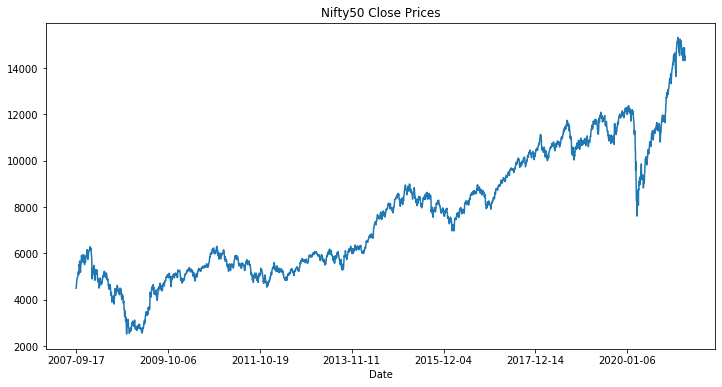

In [26]:
#plot feature to be predicted later
nifty_data['Close'].plot(figsize=(12,6),title='Nifty50 Close Prices')

In [27]:
nifty_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [28]:
#create new columns with rolling mean and stnd deviation of the data features
features=['Open', 'High', 'Low']
window1=3
window2=5
for feature in features:
    nifty_data[feature+'rolling_mean_3']=nifty_data[feature].rolling(window=window1).mean()
    nifty_data[feature+'rolling_mean_5']=nifty_data[feature].rolling(window=window2).mean()
for feature in features:
    nifty_data[feature+'rolling_stnd_3']=nifty_data[feature].rolling(window=window1).std()
    nifty_data[feature+'rolling_stnd_5']=nifty_data[feature].rolling(window=window2).std()
nifty_data.head()

,Open,High,Low,Close,Adj Close,Volume,Openrolling_mean_3,Openrolling_mean_5,Highrolling_mean_3,Highrolling_mean_5,Lowrolling_mean_3,Lowrolling_mean_5,Openrolling_stnd_3,Openrolling_stnd_5,Highrolling_stnd_3,Highrolling_stnd_5,Lowrolling_stnd_3,Lowrolling_stnd_5
Date,,,,,,,,,,,,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0,4520.933431,NaN,4613.283203,NaN,4504.883301,NaN,28.157197,NaN,108.882622,NaN,39.294093,NaN
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0,4593.066732,NaN,4683.883301,NaN,4584.316569,NaN,125.956719,NaN,114.908199,NaN,123.379293,NaN
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0,4679.350098,4610.120117,4785.183431,4691.279981,4668.366699,4593.9,112.169647,123.901624,62.038836,135.863305,102.484357,125.096564


In [29]:
nifty_data.isna().sum()

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Openrolling_mean_3    2
Openrolling_mean_5    4
Highrolling_mean_3    2
Highrolling_mean_5    4
Lowrolling_mean_3     2
Lowrolling_mean_5     4
Openrolling_stnd_3    2
Openrolling_stnd_5    4
Highrolling_stnd_3    2
Highrolling_stnd_5    4
Lowrolling_stnd_3     2
Lowrolling_stnd_5     4
dtype: int64

In [30]:
nifty_data.dropna(inplace=True)
nifty_data.isna().sum()

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Openrolling_mean_3    0
Openrolling_mean_5    0
Highrolling_mean_3    0
Highrolling_mean_5    0
Lowrolling_mean_3     0
Lowrolling_mean_5     0
Openrolling_stnd_3    0
Openrolling_stnd_5    0
Highrolling_stnd_3    0
Highrolling_stnd_5    0
Lowrolling_stnd_3     0
Lowrolling_stnd_5     0
dtype: int64

### TIME SERIES + SENTIMENT DATA MERGE

news data is only available till 2017 in the dataset. So if we use inner join, merged_Data will have data only till 2017.

In [31]:
#nifty50 data in nifty_data_mod & news data in news_data_mod
#data is merged fro 2007 and news data from 2001 to 2007 is not considered
merged_data= pd.concat([nifty_data,news_data_mod],axis=1)
merged_data.head()
#merged_data.shape

,Open,High,Low,Close,Adj Close,Volume,Openrolling_mean_3,Openrolling_mean_5,Highrolling_mean_3,Highrolling_mean_5,...,Openrolling_stnd_3,Openrolling_stnd_5,Highrolling_stnd_3,Highrolling_stnd_5,Lowrolling_stnd_3,Lowrolling_stnd_5,compound,negative,positive,neutral
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0,4679.350098,4610.120117,4785.183431,4691.279981,...,112.169647,123.901624,62.038836,135.863305,102.484357,125.096564,-0.9989,0.140,0.057,0.803
2007-09-24,4837.149902,4941.149902,4837.149902,4932.200195,4932.200195,0.0,4774.983398,4673.860059,4852.566732,4769.700000,...,54.593122,145.113488,90.190736,146.024320,63.659710,145.197594,-0.9968,0.119,0.083,0.798
2007-09-25,4939.100098,4953.899902,4878.149902,4938.850098,4938.850098,0.0,4843.066732,4762.860059,4916.916666,4850.120019,...,93.215896,143.757898,53.396937,99.252984,74.440759,127.318836,-0.3788,0.099,0.100,0.802
2007-09-26,4937.600098,4980.850098,4930.350098,4940.500000,4940.500000,0.0,4904.616699,4840.330078,4958.633301,4898.490039,...,58.432774,97.453011,20.268946,90.068058,46.712127,90.928025,-0.9922,0.128,0.097,0.775
2007-09-27,4942.700195,5016.399902,4942.700195,5000.549805,5000.549805,0.0,4939.800130,4881.900098,4983.716634,4949.600000,...,2.621122,84.707791,31.348449,59.887107,34.263989,84.401425,-0.9670,0.126,0.122,0.752


In [32]:
# save merged data to disk as csv file
merged_data.to_csv('merged_data.csv')

In [33]:
merged_data.shape

(7330, 22)

In [34]:
## lets create some new features using mutual information
merged_data['Diff_openclose']=merged_data['Close']-merged_data['Open']
merged_data['Diff_highlow']=merged_data['High']-merged_data['Low']
merged_data['Ratio_highlow']=merged_data['High']/merged_data['Low']
merged_data['Ratio_closeopen']=merged_data['Close']/merged_data['Open']
merged_data.head()

,Open,High,Low,Close,Adj Close,Volume,Openrolling_mean_3,Openrolling_mean_5,Highrolling_mean_3,Highrolling_mean_5,...,Lowrolling_stnd_3,Lowrolling_stnd_5,compound,negative,positive,neutral,Diff_openclose,Diff_highlow,Ratio_highlow,Ratio_closeopen
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0,4679.350098,4610.120117,4785.183431,4691.279981,...,102.484357,125.096564,-0.9989,0.140,0.057,0.803,84.599610,122.000000,1.025773,1.017799
2007-09-24,4837.149902,4941.149902,4837.149902,4932.200195,4932.200195,0.0,4774.983398,4673.860059,4852.566732,4769.700000,...,63.659710,145.197594,-0.9968,0.119,0.083,0.798,95.050293,104.000000,1.021500,1.019650
2007-09-25,4939.100098,4953.899902,4878.149902,4938.850098,4938.850098,0.0,4843.066732,4762.860059,4916.916666,4850.120019,...,74.440759,127.318836,-0.3788,0.099,0.100,0.802,-0.250000,75.750000,1.015528,0.999949
2007-09-26,4937.600098,4980.850098,4930.350098,4940.500000,4940.500000,0.0,4904.616699,4840.330078,4958.633301,4898.490039,...,46.712127,90.928025,-0.9922,0.128,0.097,0.775,2.899902,50.500000,1.010243,1.000587
2007-09-27,4942.700195,5016.399902,4942.700195,5000.549805,5000.549805,0.0,4939.800130,4881.900098,4983.716634,4949.600000,...,34.263989,84.401425,-0.9670,0.126,0.122,0.752,57.849610,73.699707,1.014911,1.011704


In [35]:
#MUTUAL_INFORMATION
'''def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores'''

'def make_mi_scores(X, y, discrete_features):\n    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)\n    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)\n    mi_scores = mi_scores.sort_values(ascending=False)\n    return mi_scores'

In [36]:
#decide features to include in prediction later
ind_features=['Openrolling_mean_3', 'Openrolling_mean_5', 'Highrolling_mean_3',
       'Highrolling_mean_5', 'Lowrolling_mean_3', 'Lowrolling_mean_5',
       #'Volumerolling_mean_3', 'Volumerolling_mean_5', 
       'Openrolling_stnd_3','Openrolling_stnd_5', 'Highrolling_stnd_3', 'Highrolling_stnd_5',
       'Lowrolling_stnd_3', 'Lowrolling_stnd_5',
       'compound','negative','positive','neutral',
       'Diff_openclose','Diff_highlow',
       #'Ratio_closeopen',
       'Ratio_highlow']
       #'Volumerolling_stnd_3','Volumerolling_stnd_5'

### CLEAN DATA 

In [37]:
merged_data.tail()

,Open,High,Low,Close,Adj Close,Volume,Openrolling_mean_3,Openrolling_mean_5,Highrolling_mean_3,Highrolling_mean_5,...,Lowrolling_stnd_3,Lowrolling_stnd_5,compound,negative,positive,neutral,Diff_openclose,Diff_highlow,Ratio_highlow,Ratio_closeopen
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.9996,0.123,0.088,0.789,NaN,NaN,NaN,NaN
2020-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.9998,0.125,0.075,0.800,NaN,NaN,NaN,NaN
2020-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.9517,0.095,0.099,0.806,NaN,NaN,NaN,NaN
2020-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.9996,0.133,0.101,0.766,NaN,NaN,NaN,NaN
2020-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.9993,0.110,0.073,0.817,NaN,NaN,NaN,NaN


In [38]:
#arima model gets error that the data contains infiniite values, so lets drop it.
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.dropna(inplace=True)
#np.any(np.isnan(train_data)),np.all(np.isfinite(train_data))

In [39]:
#splitting train and test data
#merged_data.shape----->(6865, 26)

train_size=int(len(merged_data)*0.65)
test_size=len(merged_data)-train_size

train_data=merged_data[:train_size]
test_data=merged_data[train_size:]

In [40]:
merged_data.isna().sum()

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Openrolling_mean_3    0
Openrolling_mean_5    0
Highrolling_mean_3    0
Highrolling_mean_5    0
Lowrolling_mean_3     0
Lowrolling_mean_5     0
Openrolling_stnd_3    0
Openrolling_stnd_5    0
Highrolling_stnd_3    0
Highrolling_stnd_5    0
Lowrolling_stnd_3     0
Lowrolling_stnd_5     0
compound              0
negative              0
positive              0
neutral               0
Diff_openclose        0
Diff_highlow          0
Ratio_highlow         0
Ratio_closeopen       0
dtype: int64

In [41]:
##PCA

### ARIMA MODEL

In [42]:
#apply auto_arima model on merged data
arima_model=auto_arima(y=train_data['Close'],
                       exogenous=train_data[ind_features],
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20941.609, Time=3.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21018.936, Time=1.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20960.547, Time=6.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20988.588, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23796.794, Time=7.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=20940.192, Time=2.89 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=20872.344, Time=8.09 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=20790.261, Time=11.63 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=20808.872, Time=9.68 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=20937.052, Time=2.67 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=20830.980, Time=10.41 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=20817.325, Time=9.86 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0] intercept
Total fit time: 74.736 seconds


In [43]:
arima_model.fit(train_data['Close'],train_data[ind_features])

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [44]:
forecast=arima_model.predict(n_periods=len(test_data),exogenous=test_data[ind_features])

In [45]:
test_data['Forecast_ARIMA']=forecast

### PERFORMANCE METRICS

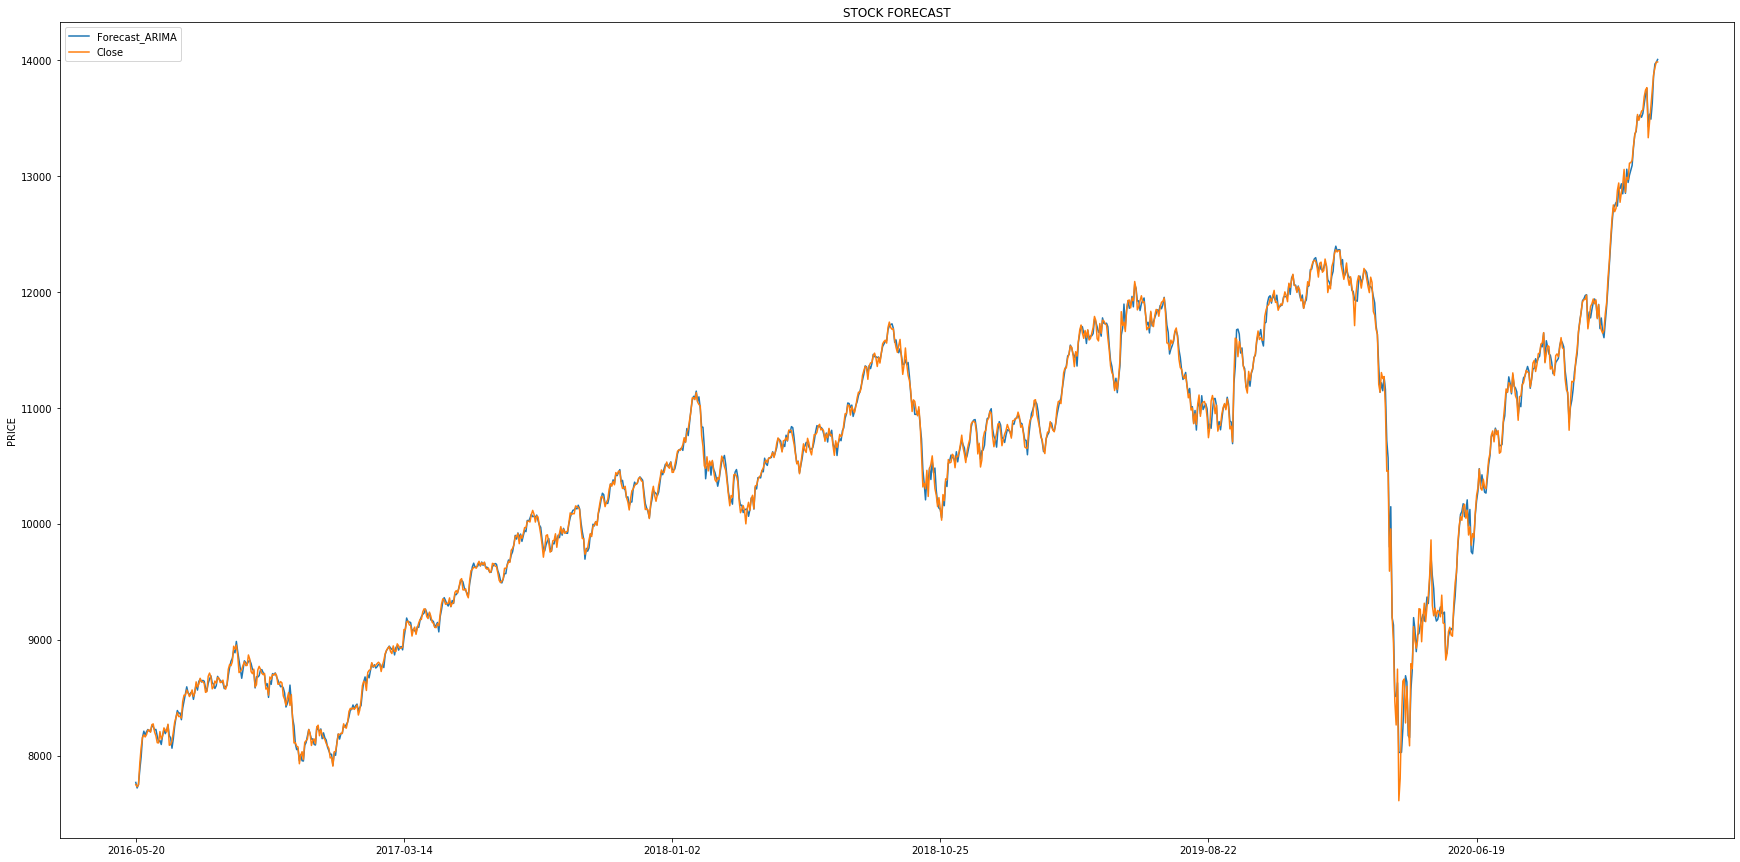

In [55]:
test_data[['Forecast_ARIMA','Close']].plot(figsize=(30,15),title='STOCK FORECAST',ylabel='PRICE')

In [56]:
MAE=mean_absolute_error(test_data['Close'],test_data['Forecast_ARIMA'])
RMSE=np.sqrt(mean_squared_error(test_data['Close'],test_data['Forecast_ARIMA']))

print('MAE:{}'.format(MAE))
print('RMSE:{}'.format(RMSE))

MAE:38.44484152534055
RMSE:58.220616179801276


In [48]:
#save model
filename = 'model.pk1'
pickle.dump(arima_model,open(filename,'wb'))


In [49]:
#load model
load_model = pickle.load(open(filename,'rb'))

#case1
MAE:47.23519594976616
RMSE:61.02465752730425

###Case2 when 2 new features included
MAE:32.21080375994192
RMSE:41.662926944378746

###Case3 when 4 news features used
MAE:31.930405840842123
RMSE:41.67104591746529